# Setup 

In [2]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
DAY_NAMES = ['lunes','martes','miércoles','jueves','viernes','sábado','domingo']

dataset = '../datasets/dataset.csv'
df = pd.read_csv(dataset, sep=',', encoding='utf-8').drop({'Unnamed: 0'}, axis=1)

Descripción de las variables
- “userid”: Identificador único del browser de navegación.
- “date”: Fecha (YYYY-MM-DD) de la sesión actual
- “cant_actions”: Cantidad de eventos del usuario en la sesión previa
- “search”: Cantidad de eventos de búsqueda de la sesión previa
- “detail”: Cantidad de eventos de detalle de la sesión previa
- “checkout”: Cantidad de eventos de checkout de la sesión previa
- “thanks”: Cantidad de eventos de compra de la sesión previa
- “comprador”: Es la variable que queremos predecir, si compró o no algún hotel.
- “comprador_sess”: Si compró un hotel en la sesión previa
- “used_tablet”: Si el dispositivo usado es una tablet
- “used_smartphone”: Si el dispositivo usado es un celular
- “timeprox”: Distancia en milisegundos entre la sesión actual y la previa
- “longsess”: Duración en milisegundos de la sesión previa
- “cantsesiones”: Cantidad de sesiones previas a la actual en los últimos 15 días
- “dur_media”: Duración media (en segundos) de la estadía buscada en la sesión previa
- “ant_media”: Anticipación media (en segundos) entre la fecha de la sesión previa y las fechas de
check-in buscadas


# Limpieza 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222989 entries, 0 to 222988
Data columns (total 16 columns):
userid             222881 non-null object
date               222989 non-null object
cant_actions       222989 non-null int64
search             222410 non-null float64
detail             222989 non-null int64
checkout           222989 non-null int64
thanks             222989 non-null int64
comprador          222989 non-null bool
comprador_sess     222989 non-null bool
used_tablet        222989 non-null object
used_smartphone    222859 non-null object
timeprox           222989 non-null int64
longsess           222989 non-null int64
cantsesiones       222989 non-null int64
dur_media          222989 non-null float64
ant_media          222989 non-null float64
dtypes: bool(2), float64(3), int64(7), object(4)
memory usage: 24.2+ MB


## Campos vacíos 

In [5]:
null_sum = df.isnull().sum()
null_sum[null_sum > 0]

userid             108
search             579
used_smartphone    130
dtype: int64

Sólo tres variables presentan valores nulos. <br>
Considero que la cantidad de registros afectados es despreciable. <br>
Como *userid* es un identificador y *used_smartphone* una columna de categoría, decido elimilar los registros con valores vacíos para esas variables.

En el caso de _search_ compruebo las proporciones del target _comprador_ para el dataset con y sin los registros donde _search_ es nulo:

In [6]:
print('search nulo')
df[df.search.isnull()].comprador.value_counts().divide(df[df.search.isnull()].comprador.count())

search nulo


False    0.968912
True     0.031088
Name: comprador, dtype: float64

In [7]:
print('search no-nulo')
df.comprador.value_counts().divide(df.comprador.count())

search no-nulo


False    0.972443
True     0.027557
Name: comprador, dtype: float64

No considero significativa la diferencia.

In [8]:
main_events = ['search','detail','checkout','thanks']

events_diff = df.cant_actions - df[main_events].sum(axis=1)
no_extra_events = (events_diff == 0)

search_null_no_extra = (df.search.isnull() & no_extra_events).sum()
search_null_no_extra

90

Considerando que *cant_actions* sumariza los eventos, si la diferencia entre esa variable y la suma de los eventos identificados es cero, asumo que no hay eventos secundarios. Podría "salvar" 90 registros de esta forma. <br>

También podría aplicar una imputación por la media de la variable; prefiero evitarlo por dado que se trata de un análisis multivariado. <br>

Priorizo minimizar la manipulación de datos y eliminar también los registros para los cuales _search_ es nula.

In [9]:
df.dropna(inplace=True)

## Corrección de tipos (_dtypes_)

### _search_

Por la definición de la variable, considero debería ser tipo _int_ y no _float_. 

In [10]:
df['search'].apply(lambda x: True if x-int(x) > 0 else False).sum()

0

No hay ningún registro con valores decimales.<br> Transformo la columna.

In [11]:
df['search'] = df['search'].astype('int64')

### *used_smartphone*

Por la definición de la variable, considero que *used_smartphone* debería ser tipo _bool_ y no _object_. 

In [12]:
vc_before_tx = df.used_smartphone.value_counts()
vc_before_tx

True     135563
False     86610
Name: used_smartphone, dtype: int64

In [13]:
df['used_smartphone'] = df['used_smartphone'].astype('bool')

vc_before_tx == df.used_smartphone.value_counts()

True     True
False    True
Name: used_smartphone, dtype: bool

### *used_tablet* 

In [14]:
df.used_tablet.value_counts()

dfg      132826
False     88081
True       1266
Name: used_tablet, dtype: int64

In [15]:
used_smartphone_true = df.used_smartphone == True

used_tablet_true = df.used_tablet.str.contains('True')
used_tablet_false = df.used_tablet.str.contains('False')
used_tablet_dfg = df.used_tablet.str.contains('dfg')

tablet_dfg_smartphone_true = ((used_tablet_dfg) & (used_smartphone_true)).sum()
diff_tablet_dfg = used_tablet_dfg.sum() - tablet_dfg_smartphone_true
diff_tablet_dfg
# df.loc[used_tablet_true,'used_tablet'] = True
# df.loc[used_tablet_false,'used_tablet'] = False

# df.loc[(used_tablet_dfg & used_smartphone_true),'used_tablet'] = False


51763

Esta variable presenta un valor desconocido para más de la mitad de los registros. <br>
Podría disminuir la cantidad de estos registros comparándola contra los casos positivos de la variable *used_smartphone*.<br>
Aún así, 51763 registros permanecerían con valor desconocido. <br>


Prefiero descartar la variable y acotar el análisis a los dispositivos, _computadora_ y _smartphone_.

In [16]:
df.drop(columns='used_tablet', inplace=True)

## Chequeo de eventos 

No hay registros donde *cant_actions* sea menor que la suma de los eventos principales.

In [17]:
main_events = ['search','detail','checkout','thanks']

events_diff = df.cant_actions - df[main_events].sum(axis=1)
bad_events = (events_diff < 0).sum()
bad_events


0

## Agrego columnas auxiliares

In [18]:
df['weekday'] = pd.DatetimeIndex(df.date).weekday
df['day'] = pd.DatetimeIndex(df.date).day

# Exploración 

## Período considerado

In [19]:
print('Inicio: {}, Fin: {}'.format(df.date.min(),df.date.max()))

Inicio: 2018-05-14, Fin: 2018-06-12


## Total de sesiones por día de la semana 

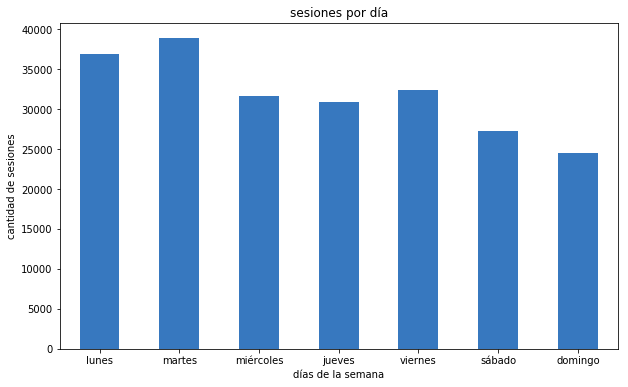

In [20]:
df.weekday.value_counts(sort=False).sort_index().plot(kind='bar',figsize=[10,6], color=sns.xkcd_rgb["windows blue"])
plt.xticks(ticks=np.arange(7),labels=DAY_NAMES, rotation=0);
plt.xlabel('días de la semana')
plt.ylabel('cantidad de sesiones')
plt.title('sesiones por día');

## Usuarios

In [21]:
print('Cantidad de usuarios únicos {}.'.format(df.userid.nunique()))

Cantidad de usuarios únicos 98211.


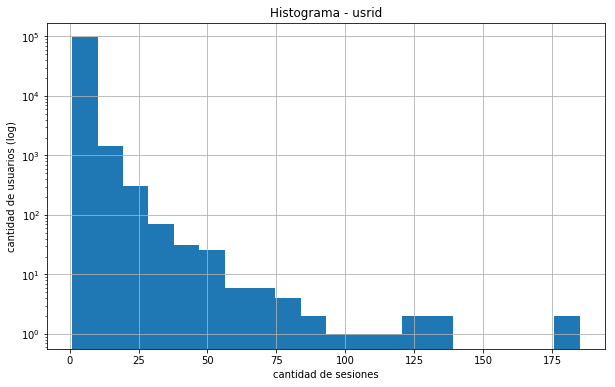

In [22]:
df.userid.value_counts().to_frame().hist(bins=20, figsize=[10,6]);
plt.yscale('log')
plt.xlabel('cantidad de sesiones')
plt.ylabel('cantidad de usuarios (log)');
plt.title('Histograma - usrid');

# Probabilidad de compra

Elijo el modelo KNeighbors para clasificar las sesiones registradas. <br>
Entreno al modelo con el 30% de los datos. Reservo un 70% para medir el rendimiento del mismo. 



In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

X = df.drop(['userid','date','comprador'], axis=1).values
y = df.comprador.values

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.7, random_state=42)

knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train, y_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

Calculo las probabilidades 

In [24]:
df_predict_proba = pd.DataFrame(knn.predict_proba(X_test), columns=['no_comprador_pred','comprador_pred'])

In [25]:
df_predict_proba.describe().loc['mean',:].to_frame()

,mean
no_comprador_pred,0.973723
comprador_pred,0.026277


In [26]:
print('Score del modelo: {:.4f}'.format(knn.score(X_test, y_test))) 

Score del modelo: 0.9720


## Importancia de las variables

Utilicé el modelo lineal Lasso para hacer una regresión y evaluar la importancia de las variables. <br> 
Teniendo en cuenta que el período está sujeto fuertemente a factores estacionales, si tuviera que quedarme con dos, serían:
- *longsess*: Duración en milisegundos de la sesión previa, y
- *dur_media*: Duración media (en segundos) de la estadía buscada en la sesión previa

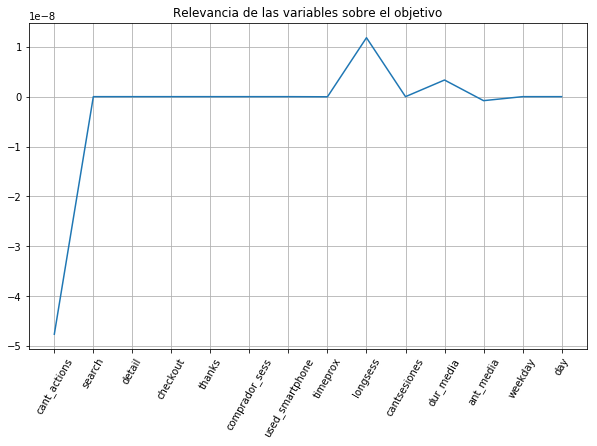

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

X = df.drop(['userid','date','comprador'], axis=1).values
y = df.comprador.values

names = df.drop(['userid','date', 'comprador'], axis=1).columns

lasso = Lasso(alpha=0.1)
lasso_coef = lasso.fit(X, y).coef_

plt.figure(figsize=[10,6])
plt.plot(range(len(names)), lasso_coef)
plt.xticks(range(len(names)), names, rotation=60)
plt.grid()
plt.title('Relevancia de las variables sobre el objetivo');

## Probabilidad en función de la cantidad de eventos

Agrupo las probabilidades por cantida de enventos en la sesión anterior, y calculo la media sobre la probabilidad de que el usuario compre. <br>
A partir de los 50 eventos por sesión, la dispersión en la probabilidad media de compra es significativa y no pareciera haber una clara correlación entre la cantida de registros y la probabilidad de compra.

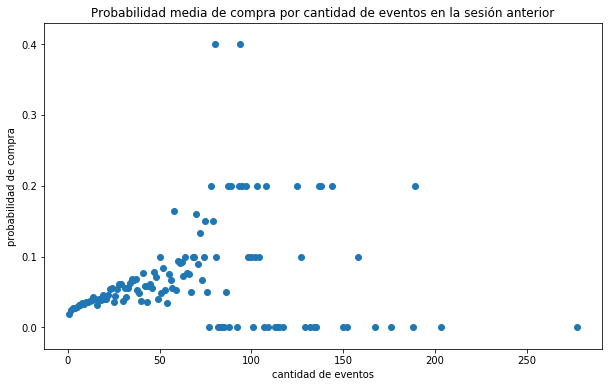

In [28]:
df_X_test = pd.DataFrame(X_test, columns=df.drop(['userid','date','comprador'], axis=1).columns)
df_merged = df_X_test.merge(df_predict_proba, left_index=True, right_index=True)

# df_merged.groupby('cant_actions')['comprador_pred'].mean().Transpose.hist()
comprador_cant_actions = df_merged.groupby('cant_actions')['comprador_pred'].mean().reset_index()

outliers = comprador_cant_actions.cant_actions > 400

comprador_cant_actions = comprador_cant_actions[~outliers]

plt.figure(figsize=[10,6])
plt.scatter(x = comprador_cant_actions.cant_actions, y=comprador_cant_actions.comprador_pred)
plt.xlabel('cantidad de eventos')
plt.ylabel('probabilidad de compra')
plt.title('Probabilidad media de compra por cantidad de eventos en la sesión anterior');

In [29]:
outliers.sum()/outliers.count()*100;

En el gráfico anterior excluyo a las sesiones con más de 400 eventos para una visualización más clara. Estas sesiones representan apenas un 6% del subset considerado.